In [2]:
# https://unit8co.github.io/darts/quickstart/00-quickstart.html#Machine-learning-and-global-models

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries

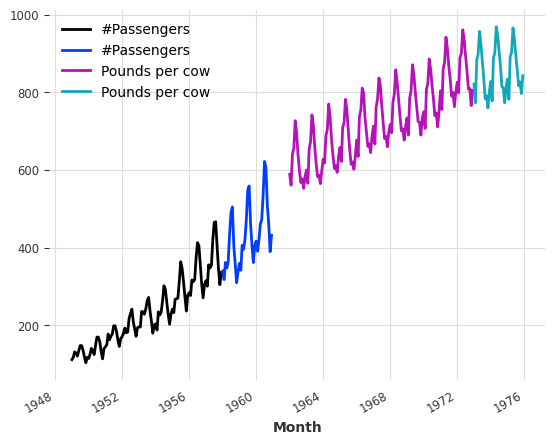

In [3]:
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

series_air = AirPassengersDataset().load().astype(np.float32)
series_milk = MonthlyMilkDataset().load().astype(np.float32)

# set aside last 36 months of each series as validation set:
train_air, val_air = series_air[:-36], series_air[-36:]
train_milk, val_milk = series_milk[:-36], series_milk[-36:]

train_air.plot()
val_air.plot()
train_milk.plot()
val_milk.plot()

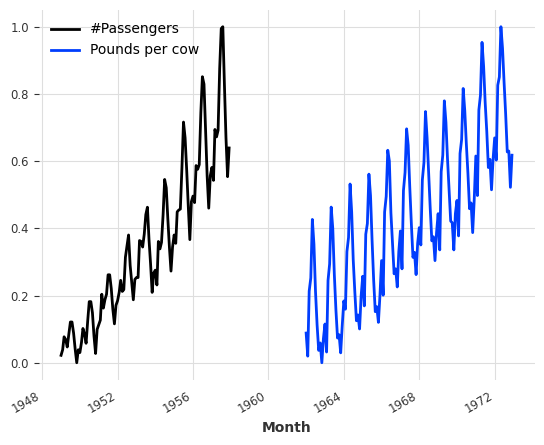

In [4]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
train_air_scaled, train_milk_scaled = scaler.fit_transform([train_air, train_milk])

train_air_scaled.plot()
train_milk_scaled.plot()

In [5]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit([train_air_scaled, train_milk_scaled], epochs=50, verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

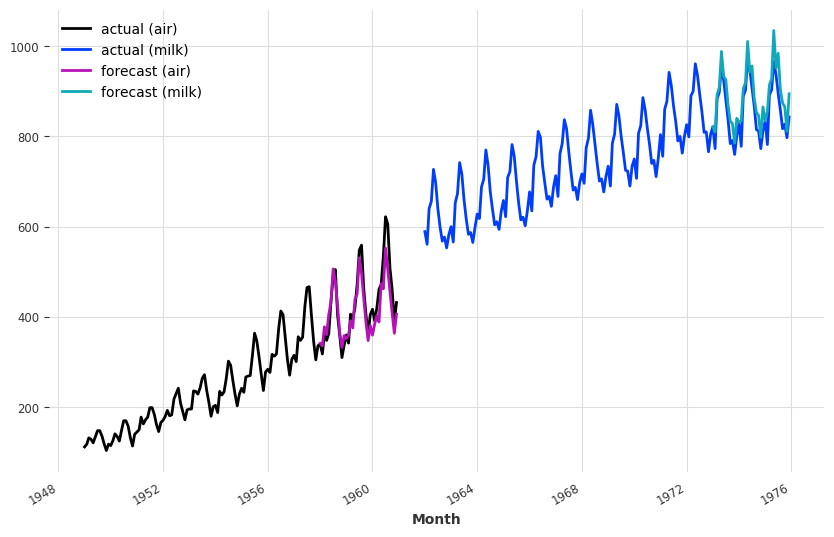

In [6]:
pred_air = model.predict(series=train_air_scaled, n=36)
pred_milk = model.predict(series=train_milk_scaled, n=36)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

Covariates (external data)

Text(0.5, 1.0, 'one multivariate time series of 2 dimensions, containing covariates for the air series:')

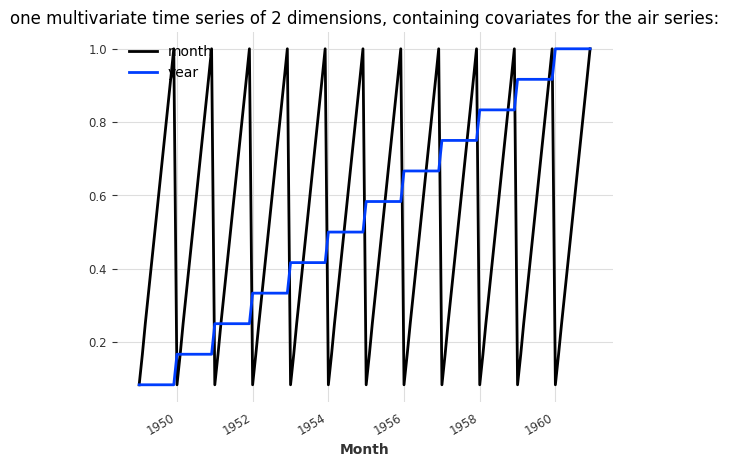

In [7]:
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

air_covs = concatenate(
    [
        dt_attr(series_air.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series_air.time_index, "year", dtype=np.float32) - 1948) / 12,
    ],
    axis="component",
)

milk_covs = concatenate(
    [
        dt_attr(series_milk.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series_milk.time_index, "year", dtype=np.float32) - 1962) / 13,
    ],
    axis="component",
)

air_covs.plot()
plt.title(
    "one multivariate time series of 2 dimensions, containing covariates for the air series:"
)

In [8]:
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit(
    [train_air_scaled, train_milk_scaled],
    past_covariates=[air_covs, milk_covs],
    epochs=50,
    verbose=True,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.6 M 
---------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable params
6.6 M     Total params
26.314    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Using encoders

In [ ]:
# encoders = {
#    "cyclic": {"future": ["month"]},
#    "datetime_attribute": {"future": ["hour", "dayofweek"]},
#    "position": {"past": ["absolute"], "future": ["relative"]},
#    "custom": {"past": [lambda idx: (idx.year - 1950) / 50]},
#    "transformer": Scaler(),
#}

In [9]:
encoders = {"datetime_attribute": {"past": ["month", "year"]}, "transformer": Scaler()}

In [10]:
model = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    add_encoders=encoders,
    random_state=42,
)

model.fit([train_air_scaled, train_milk_scaled], epochs=50, verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.6 M 
---------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable params
6.6 M     Total params
26.314    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

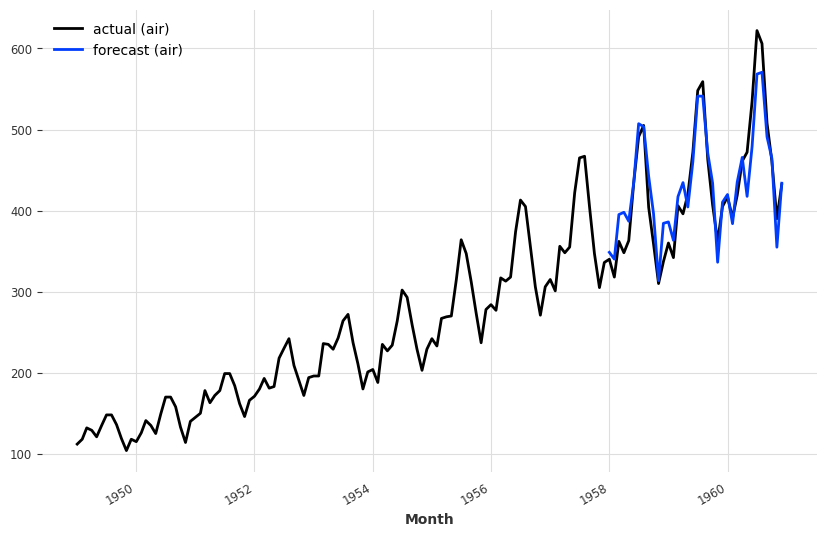

In [11]:
pred_air = model.predict(series=train_air_scaled, n=36)

# scale back:
pred_air = scaler.inverse_transform(pred_air)

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
pred_air.plot(label="forecast (air)")

Regression

In [12]:
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge

model = RegressionModel(lags=72, lags_future_covariates=[-6, 0], model=BayesianRidge())

model.fit(
    [train_air_scaled, train_milk_scaled], future_covariates=[air_covs, milk_covs]
);

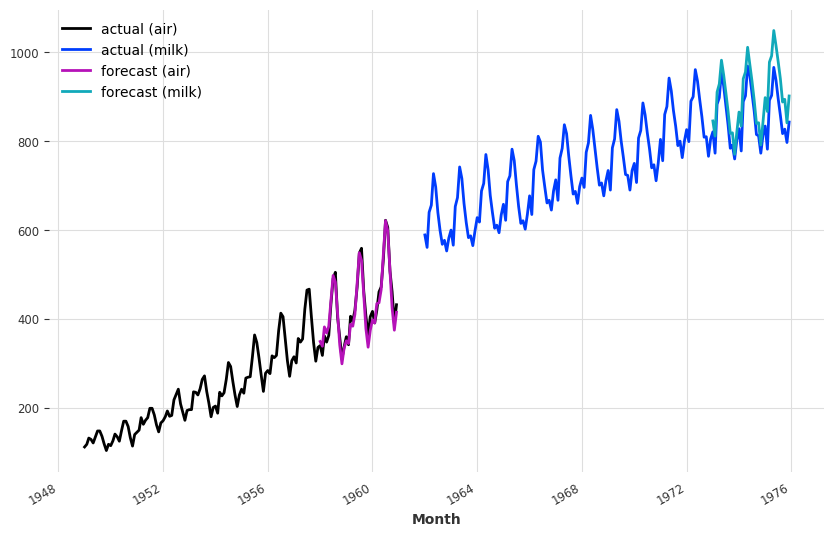

In [13]:
pred_air, pred_milk = model.predict(
    series=[train_air_scaled, train_milk_scaled],
    future_covariates=[air_covs, milk_covs],
    n=36,
)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

In [15]:
from darts.metrics import mape
mape([series_air, series_milk], [pred_air, pred_milk])

[3.417085111141205, 5.28305396437645]

  0%|          | 0/57 [00:00<?, ?it/s]

MAPE = 3.66


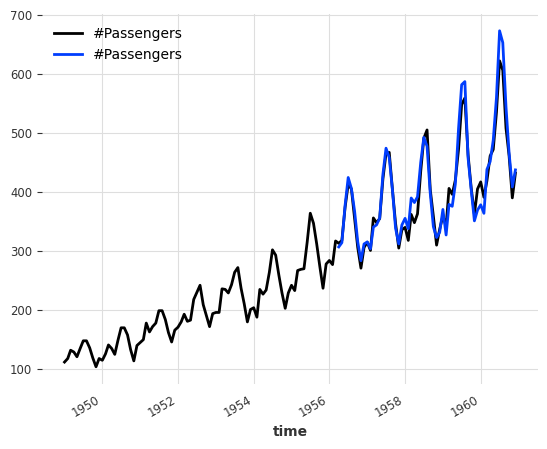

In [16]:
bayes_ridge_model = RegressionModel(
    lags=72, lags_future_covariates=[0], model=BayesianRidge()
)

backtest = bayes_ridge_model.historical_forecasts(
    series_air, future_covariates=air_covs, start=0.6, forecast_horizon=3, verbose=True
)

print("MAPE = %.2f" % (mape(backtest, series_air)))
series_air.plot()
backtest.plot()

Probabilistic forecast

In [19]:
from darts.models import TCNModel
from darts.utils.likelihood_models import LaplaceLikelihood

model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=LaplaceLikelihood(),
)

model.fit(train_air_scaled, epochs=400, verbose=True);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 166   
----------------------------------------------------
166       Trainable params
0         Non-trainable params
166       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

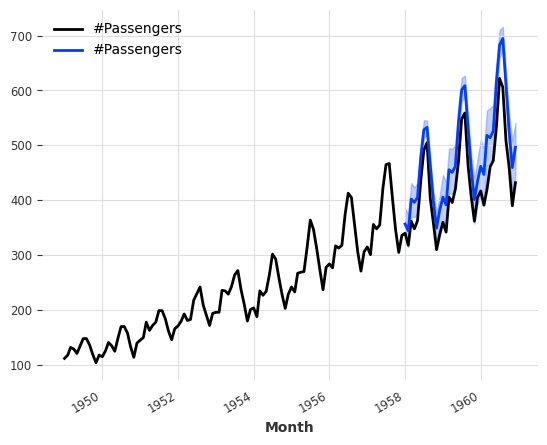

In [20]:
pred = model.predict(n=36, num_samples=500)

# scale back:
pred = scaler.inverse_transform(pred)

series_air.plot()
pred.plot()

Prior 

In [ ]:
model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=LaplaceLikelihood(prior_b=0.1),
)

model.fit(train_air_scaled, epochs=400, verbose=True);

In [ ]:
pred = model.predict(n=36, num_samples=500)

# scale back:
pred = scaler.inverse_transform(pred)

series_air.plot()
pred.plot()

In [ ]:
pred.plot(low_quantile=0.01, high_quantile=0.99, label="1-99th percentiles")
pred.plot(low_quantile=0.2, high_quantile=0.8, label="20-80th percentiles")

In [ ]:
from darts.metrics import rho_risk

print("MAPE of median forecast: %.2f" % mape(series_air, pred))
for rho in [0.05, 0.1, 0.5, 0.9, 0.95]:
    rr = rho_risk(series_air, pred, rho=rho)
    print("rho-risk at quantile %.2f: %.2f" % (rho, rr))

In [ ]:
from darts.utils.likelihood_models import QuantileRegression

model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]),
)

model.fit(train_air_scaled, epochs=400, verbose=True);

In [ ]:
pred = model.predict(n=36, num_samples=500)

# scale back:
pred = scaler.inverse_transform(pred)

series_air.plot()
pred.plot()

print("MAPE of median forecast: %.2f" % mape(series_air, pred))
for rho in [0.05, 0.1, 0.5, 0.9, 0.95]:
    rr = rho_risk(series_air, pred, rho=rho)
    print("rho-risk at quantile %.2f: %.2f" % (rho, rr))

Ensembling models

In [ ]:
#Naive ensembling
pred = model.predict(n=36, num_samples=500)

# scale back:
pred = scaler.inverse_transform(pred)

series_air.plot()
pred.plot()

print("MAPE of median forecast: %.2f" % mape(series_air, pred))
for rho in [0.05, 0.1, 0.5, 0.9, 0.95]:
    rr = rho_risk(series_air, pred, rho=rho)
    print("rho-risk at quantile %.2f: %.2f" % (rho, rr))

In [ ]:
# Learning ensembling

from darts.models import RegressionEnsembleModel

models = [NaiveDrift(), NaiveSeasonal(12)]

ensemble_model = RegressionEnsembleModel(
    forecasting_models=models, regression_train_n_points=12
)

backtest = ensemble_model.historical_forecasts(
    series_air, start=0.6, forecast_horizon=3, verbose=True
)

print("MAPE = %.2f" % (mape(backtest, series_air)))
series_air.plot()
backtest.plot()

In [ ]:
ensemble_model.fit(series_air)
ensemble_model.regression_model.model.coef_